In [1]:
from load import *
from torch import Tensor, nn
import torch
from model_base import *
from modules import *
from anim import *
import util
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings

ROOT = "./Datas/Week 8"

Q = 1.60217663e-19

In [2]:
sc = load_space_charge() * -Q
ep = load_elec_potential()
vg = load_vgs()
poi = NormalizedPoissonMSE('cpu')
poi(ep, sc)

tensor(5.3032e-10, dtype=torch.float64)

In [3]:
def extract(ep, sc):
    xep = ep.reshape(-1, 129, 17)
    xsc = sc.reshape(-1, 129, 17)
            
    ep_region_2 = xep[:, 45:84,:11].reshape(-1, 429)
    ep_region_5 = xep[:, 45:84,11:].reshape(-1, 234)
    sc_region_2 = xsc[:, 45:84,:11].reshape(-1, 429)

    joined = torch.cat([ep_region_2, ep_region_5, sc_region_2], dim = 1)

    return joined

def reconstruct(x, xep, xsc):
    ep_region_2 = x[:, :429].reshape(-1, 39, 11)
    ep_region_5 = x[:, 429:663].reshape(-1, 39, 6)
    sc_region_2 = x[:, 663:].reshape(-1, 39, 11)

    xep = xep.clone()
    xep[:, 45:84,:11] = ep_region_2
    xep[:, 45:84,11:] = ep_region_5
    xep = xep.reshape(-1, 129, 17)

    xsc = xsc.clone()
    xsc[:, 45:84,:11] = sc_region_2
    xsc = xsc.reshape(-1, 129, 17)

    return xep, xsc

In [4]:
index = util.TRAINING_IDXS[f"First 30"]

x = vg[index]
epy = ep[index]
scy = sc[index]

ep_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, epy.reshape(-1, 2193))
sc_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, scy.reshape(-1, 2193))

pca = PrincipalComponentExtractor(1092, device = 'cpu')
extracted = extract(epy, scy)
pca.fit(extracted)
X = pca.project(extracted)

In [5]:
def f(x, y):
    X = torch.tensor([[x, y]])
    X = pca.unproject(X)
    rep, rsc = reconstruct(X, epy[-1:], scy[-1:])
    rpl = NormalizedPoissonRMSE('cpu')
    mse = rpl(rep, rsc)
    return mse.item()

heatmat_fn_plot(f, xrange=(-100, 100), yrange=(-100, 100), resolution=100)

c:\Users\Darin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10000 [00:03<?, ?it/s]


NameError: name 'torch' is not defined

In [ ]:
with open("eigenvalues.txt", 'w') as f:
    for i in range(3, 101):
        index = util.TRAINING_IDXS[f"First {i}"]

        x = vg[index]
        epy = ep[index]
        scy = sc[index]

        ep_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, epy.reshape(-1, 2193))
        sc_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, scy.reshape(-1, 2193))

        pca = PrincipalComponentExtractor(1092, device = 'cpu')
        extracted = extract(epy, scy)
        pca.fit(extracted)
        
        print_first_n_eigenvalues = 10
        f.write(f"Eigenvalues: {', '.join([f'{x.item():.2f} ({x.item()/torch.sum(pca.eigenvalues).item()*100}%)' for x in pca.eigenvalues[:print_first_n_eigenvalues]])}")
        f.write("\n")

        # a = pca.project(extracted).cpu().numpy()[:, :print_first_n_eigenvalues]
        # fig, ax = plt.subplots()
        # ax.plot(a)
        # fig.suptitle("Principal component of reconstructible region")
        # pass

        # xp = pca.project(extracted)


(10, 98)


Text(0.5, 0.98, 'Principal component proportions')

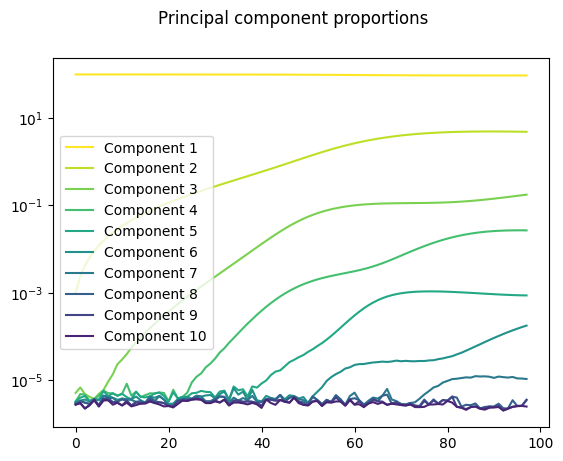

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

fig, ax = plt.subplots()
with open('eigenvalues.txt', 'r') as f:
    percentages = []
    for l in f.readlines():
        pers = []
        for i in range(10):
            p = float(l.split("(")[i+1].split(")")[0][:-1])
            pers.append(p)
        percentages.append(pers)
att = np.array(percentages).T
print(att.shape)
for i in range(10):
    ax.plot(att[i], c = colormaps['viridis'](1 - 0.1 * i), label=f"Component {i+1}")
ax.legend()
ax.set_yscale('log')
fig.suptitle("Principal component proportions")
